# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle
import gc


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as p
import torch 

from tqdm import tqdm
import uuid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Constants 

In [2]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_polarity' )

# TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'train.csv')
# TEST_DATAPATH = os.path.join(DATASET_PATH, 'test.csv')

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_train_5%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_test_1%.csv')


OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)
    
SAMPLE_SIZE = 0.2
BATCH_SIZE =  64
MAX_SEQUENCE_LENGTH = 512
MODEL_NAME = 'prajjwal1/bert-small'
id = str(uuid.uuid4()).split('-')[0]

EXP_NAME = f'baseline_{id}'
print(EXP_NAME)

baseline_82a625cd


# Process data

In [3]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [4]:
train_df = pd.read_csv(CLEANED_TRAIN_DATAPATH)
train_df.drop('title', axis = 1, inplace=True)
NUM_CLASSES = len(train_df['review'].unique())
test_df = pd.read_csv(CLEANED_TEST_DATAPATH)
test_df.drop('title', axis = 1, inplace=True)

In [5]:
train_df.dropna(inplace=True)
print(train_df.isna().sum())
print(train_df.shape)
train_df.head()

review    0
text      0
dtype: int64
(179990, 2)


,review,text
0,0,I bought one of these from Car Toys at the sam...
1,0,"I've purchased this light twice, once from Son..."
2,1,"My son's psychiatrist recommended ""The Explosi..."
3,0,Me and my friend sara and cory read this horri...
4,0,I have a somewhat bizarre story. I saw the pro...


In [6]:
test_df.dropna(inplace=True)
print(test_df.isna().sum())
print(test_df.shape)
test_df.head()

review    0
text      0
dtype: int64
(4000, 2)


,review,text
0,1,Art Asylum basically shrunk Nimoy for this toy...
1,1,"I bought this for my grandson, when he sleeps ..."
2,0,I really do like these containers. I have abou...
3,1,A friend recommended this book to me a few yea...
4,0,"I wish I would have read other reviews, but I ..."


# Dataset

In [7]:
class AmazonReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df['text'].iloc[idx]
        label = self.df['review'].iloc[idx]

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            # pad_to_max_length = True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids = pad_sequence(input_ids, batch_first=True)
    attention_mask = pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# BERT pretrained

In [8]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Create dataset and dataloader

In [9]:
# all_df = pd.concat([train_df, test_df]) 
# del train_df
# del test_df 

total_train_len = len(train_df)
train_len = int(0.9 * total_train_len) 
val_len = (total_train_len - train_len)

train_dataset = AmazonReviewDataset(train_df, tokenizer, max_length=MAX_SEQUENCE_LENGTH)
test_dataset = AmazonReviewDataset(test_df, tokenizer, max_length=MAX_SEQUENCE_LENGTH)

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print('train dataloader = ', len(train_dataloader))
print('valid dataloader = ', len(val_dataloader))
print('test dataloader = ', len(test_dataloader))

sample = next(iter(train_dataloader))
print('sample input ids = ', sample['input_ids'].shape)
print('sample attention mask = ', sample['attention_mask'].shape)
print('sample label shape = ', sample['labels'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


train dataloader =  2532
valid dataloader =  282
test dataloader =  63
sample input ids =  torch.Size([64, 242])
sample attention mask =  torch.Size([64, 242])
sample label shape =  torch.Size([64])


# Training utils

In [10]:
def get_accuracy(predictions, labels):
    return (predictions == labels).sum() / len(labels)

def train(dataloader, model, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    loop = tqdm(dataloader, desc="training...")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(loss.detach().cpu().item())
        epoch_accs.append(accuracy.detach().cpu().item())

    gc.collect()
    torch.cuda.empty_cache()

    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc="evaluating..."):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(output.loss.item())
        epoch_accs.append(accuracy.item())

    gc.collect()
    torch.cuda.empty_cache()
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def plot(history, save_fig = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))

    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_fig:
        plt.savefig(save_fig)
    if show:
        plt.show()
    plt.clf()

def tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader, epochs = 10, label = EXP_NAME, history = None):
    SAVE_PATH = os.path.join(OUTPUT_PATH, label)
    PLOT_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    best_valid_loss = float("inf")
    if history == None:
        history = collections.defaultdict(list)

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, device)
        test_loss, test_acc = evaluate(test_dataloader, model, device)

        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss 
            torch.save(model, os.path.join(SAVE_PATH, 'bert.checkpoint.torch'))

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

        plot(history, save_fig=PLOT_PATH)

        with open(os.path.join(SAVE_PATH, 'history.pickle'), 'wb') as file:
            pickle.dump(history, file)

    
    plot(history, show=True)

    



# Tune

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA Device Name: NVIDIA GeForce RTX 3060


evaluating...: 100%|██████████| 63/63 [00:12<00:00,  5.21it/s]


epoch: 0
train_loss: 0.232, train_acc: 0.906
val_loss: 0.182, valid_acc: 0.929
test_loss: 0.192, test_acc: 0.927


evaluating...: 100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


epoch: 1
train_loss: 0.152, train_acc: 0.943
val_loss: 0.192, valid_acc: 0.926
test_loss: 0.205, test_acc: 0.924


evaluating...: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


epoch: 2
train_loss: 0.110, train_acc: 0.960
val_loss: 0.235, valid_acc: 0.924
test_loss: 0.261, test_acc: 0.912


evaluating...: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


epoch: 3
train_loss: 0.080, train_acc: 0.972
val_loss: 0.242, valid_acc: 0.925
test_loss: 0.269, test_acc: 0.921


evaluating...: 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]


epoch: 4
train_loss: 0.061, train_acc: 0.980
val_loss: 0.312, valid_acc: 0.919
test_loss: 0.309, test_acc: 0.919


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

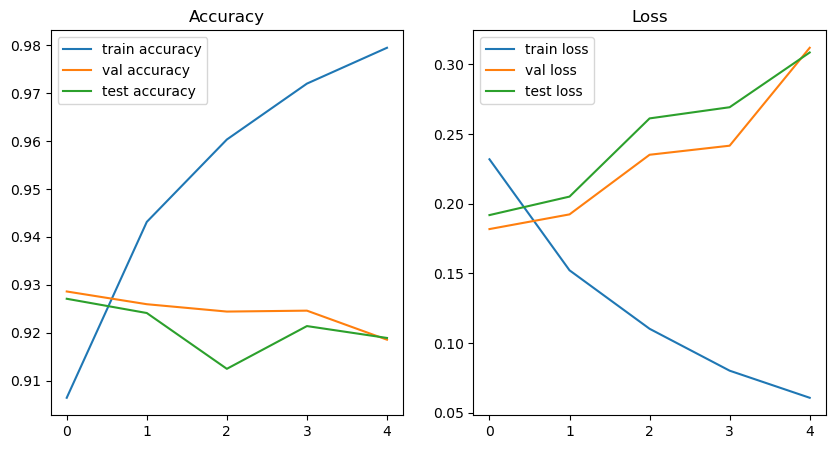

<Figure size 640x480 with 0 Axes>

In [11]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print("CUDA Device Name:", device_name)
training_epochs = 5

tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader,
      epochs = training_epochs, label = EXP_NAME) 

In [12]:
tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader,
      epochs = training_epochs, label = 'tiny_bert_10%_amazon_256_max_len')

training...:   1%|          | 23/2532 [00:08<15:22,  2.72it/s]


KeyboardInterrupt: 

# Journal

- processing the data on the fly like what AmazonReviewDataset is doing yields low GPU and CPU ultilization
- overfits in test set. Try applying regularization, increased train size, reduced test size. (maybe because bert-tiny is not enough)
- how to release GPU memory after each iteration? 